<a href="https://colab.research.google.com/github/alexisdr/uned-tfg-deteccion-eas/blob/main/UNED-TFG-4-inferencia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uso del modelo

Este cuaderno permite usar el modelo para efectuar una clasificación de texto

# Parámetros
* ruta_base: ruta en la que se encuentran los datos del corpus
* ruta_dataset: ruta en el que se almacenará el dataset
* usar_subconjunto_datos_codigos_mas_frecuentes: se usarán los actos clínicos que implican los códigos más frecuentes
* umbral: valor de corte que deberán superar las predicciones para tomarlas como ciertas

In [ ]:
ruta_base = '/drive/My Drive/CorpusPFG/'

#Datasets procesados
ruta_dataset = ruta_base + 'Dataset-completo'
modelo_base = "alexisdr/uned-tfg-08.69_mas_frecuentes"
usar_subconjunto_datos_codigos_mas_frecuentes = True
umbral = 0.9

Instalación de depndencias necesarias

In [ ]:
#Debido a la actualización de dependencias base de Google Colab, 
#es necesario ejecutar este paso, reiniciar el entorno (RESTART RUNTIME), 
#y ejectuar todos los pasos
!pip install datasets transformers[sentencepiece] 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Carga de datos del dataset

In [ ]:
from google.colab import drive

drive.mount('/drive')

Mounted at /drive


In [ ]:
from datasets import DatasetDict

dataset = DatasetDict.load_from_disk(ruta_dataset)

dataset  

DatasetDict({
    train: Dataset({
        features: ['acto', 'label', 'label_str', 'label_list', 'label_list_str', 'informes', 'text', 'json'],
        num_rows: 13051
    })
    validation: Dataset({
        features: ['acto', 'label', 'label_str', 'label_list', 'label_list_str', 'informes', 'text', 'json'],
        num_rows: 1451
    })
    test: Dataset({
        features: ['acto', 'label', 'label_str', 'label_list', 'label_list_str', 'informes', 'text', 'json'],
        num_rows: 3629
    })
    trainMasFrecuentes: Dataset({
        features: ['acto', 'label', 'label_str', 'label_list', 'label_list_str', 'informes', 'text', 'json'],
        num_rows: 639
    })
    validationMasFrecuentes: Dataset({
        features: ['acto', 'label', 'label_str', 'label_list', 'label_list_str', 'informes', 'text', 'json'],
        num_rows: 72
    })
    testMasFrecuentes: Dataset({
        features: ['acto', 'label', 'label_str', 'label_list', 'label_list_str', 'informes', 'text', 'json'],
     

In [ ]:
train = "train"
validation = "validation"
test = "test"

if (usar_subconjunto_datos_codigos_mas_frecuentes):
  train = "trainMasFrecuentes"
  validation = "validationMasFrecuentes"
  test = "testMasFrecuentes"

In [ ]:
from datasets import ClassLabel

class2label = dataset[train].features["label"]
print(class2label)

ClassLabel(names=['T38.0X5A', 'T45.515A', 'T50.2X5A', 'Y95', 'P01.1', 'T81.4XXA', 'T45.1X5A', 'Y83.1'], id=None)


In [ ]:
class2label.num_classes

8

# Preprocesado de los datos

El modelo no puede recibir texto como entrada, se ha de convertir a tokens.

In [ ]:
from transformers import AutoTokenizer


tokenizer = AutoTokenizer.from_pretrained(modelo_base)

def preprocess_data(examples):
  return tokenizer(examples["text"], padding="max_length", truncation=True, return_tensors="pt")

# Cálculo de la métrica S

In [ ]:
#Calcula el prefico comun entre 2 códigos
def calculo_lcs(codigo_i, codigo_j):
  if codigo_i is None or codigo_j is None:
    return ""

  #Se omiten los puntos existenten en los códigos
  codigo_i = codigo_i.replace(".", "")
  codigo_j = codigo_j.replace(".", "")

  #Tomamos el tamaño mínimo
  size = min(len(codigo_i), len(codigo_j)) 

  lcs_i_j = ''
  for i in range(size):
    if codigo_i[i] == codigo_j[i]:
      lcs_i_j = lcs_i_j + codigo_i[i]
    else:
      return lcs_i_j
  
  return lcs_i_j


#Devuelve la longitud de la cadena de caracteres C
#si esta vale al menos 3, y devuelve 0 si dicha longitud es menor que 3. 
#Esto se debe a que los códigos CIE-10 más cortos contienen al menos 3 caracteres.
def calculo_ic(codigo):
  #Se omiten los puntos existenten en los códigos
  codigo = codigo.replace(".", "")

  tamanyo = len(codigo)
  if (tamanyo < 3):
    return 0
  else:
    return tamanyo

#similitud entre 2 códigos CIE-10 𝑖 y 𝑗:
def calculo_c(codigo_i, codigo_j):
  divisor = calculo_ic(codigo_i) + calculo_ic(codigo_j)
  if (divisor == 0):
    return 0
  dividendo = 2 * calculo_ic(calculo_lcs(codigo_i, codigo_j))
  c_i_j = dividendo / divisor
  return round(c_i_j, 6)

def metrica_s(lista_codigos_i, lista_codigos_j): 
  #las listas deben tener valores 
  if (len(lista_codigos_i) == 0 or len(lista_codigos_j) == 0):
    return 0

  #max (Ng, Ns)
  divisor = max(len(lista_codigos_i), len(lista_codigos_j)) 
  if (divisor == 0):
    return 0
  
  max_c_i_j = 0
  for codigo_j in lista_codigos_j:
    max_local_c_i_j = 0
    for codigo_i in lista_codigos_i:
      c_i_j = calculo_c(codigo_i, codigo_j)
      if (c_i_j > max_local_c_i_j):
        max_local_c_i_j = c_i_j
    max_c_i_j += max_local_c_i_j

  s = max_c_i_j / divisor
  return round(s, 6)

def metrica_s_train (y_true, y_pred):     
    y_true_labels = []
    true_labels = [class2label.int2str([idx])for idx, label in enumerate(y_true) if label == 1.0]
    for label in true_labels:
      y_true_labels.append(label[0])

    y_pred_labels = []
    pred_labels = [class2label.int2str([idx])for idx, label in enumerate(y_pred) if label == 1.0]
    for label in pred_labels:
      y_pred_labels.append(label[0])

    return metrica_s(y_true_labels, y_pred_labels)

# Inferencia

Se ejecuta el modelo contra datos de test

**Cálculo de predicciones**

Solo asignar NONE si su probabilidad es mayor que la del resto de códigos y en caso contrario asignar sólo los códigos con mayor probabilidad que NONE

In [ ]:
dataset[test]

Dataset({
    features: ['acto', 'label', 'label_str', 'label_list', 'label_list_str', 'informes', 'text', 'json'],
    num_rows: 175
})

In [ ]:
codigo_NONE = 'NONE'

def calcular_predicciones(probs, threshold=umbral):
  predictions = np.zeros(probs.shape)
  predictions[np.where(probs > threshold)] = 1
  return predictions

def calcular_predicciones_NONE_mas_probable(probs, threshold=umbral):
  predictions = calcular_predicciones(probs, threshold)

  try:
    probabilidad_NONE = probs[class2label.str2int(codigo_NONE)]
    #Se ha encontrado NONE entre las predicciones
    if (probabilidad_NONE > 0):
      predictions_mayor_que_prob_NONE = np.zeros(probs.shape)
      predictions_mayor_que_prob_NONE[np.where(probs > probabilidad_NONE)] = 1
      # Si hay labels con mejor probabilidad que none nos la quedamos
      if (1 in predictions_mayor_que_prob_NONE):
        predictions = predictions_mayor_que_prob_NONE
      else: #Si no las hay nos quedamos solo con NONE
        predictions[:] = 0
        predictions[class2label.str2int(codigo_NONE)] = 1
  except ValueError:
    pass      
    
  return predictions
    
#Solo asignar NONE si existe y tiene una probabilidad que supere el umbral
def calcular_predicciones_existe_NONE(probs, threshold=umbral):
  predictions = calcular_predicciones(probs, threshold)

  try:
    probabilidad_NONE = probs[class2label.str2int(codigo_NONE)]
    #Se ha encontrado NONE entre las predicciones, nos la quedamos de forma exclusiva
    if (probabilidad_NONE > threshold):
        predictions[:] = 0
        predictions[class2label.str2int(codigo_NONE)] = 1
  except ValueError:
    pass

  return predictions

In [ ]:
# obtienen los nombres de las etiquetas predichas
def obtener_lables_predichas (y_pred):
  predicted_labels = [class2label.int2str([idx])for idx, label in enumerate(y_pred) if label == 1.0]
  y_pred_labels = []
  for label in predicted_labels:
      y_pred_labels.append(label[0])
  return y_pred_labels

# obtienen el vector y_true a partir de los labels 
def obtener_y_true (labels):
  # crea una matriz del tamaño del texto y las clases a entrenar
  labels_matrix = np.zeros(class2label.num_classes)
  for clase in labels:
    try:
      indice_clase = class2label.str2int(clase)
      labels_matrix[indice_clase] = 1
    except:
      print("La clase %s no está entre las clases de entrenamiento" % clase)
  return labels_matrix.tolist()

In [ ]:
data = dataset[test][6]
data

{'acto': 26691591,
 'label': 0,
 'label_str': 'T38.0X5A',
 'label_list': [0],
 'label_list_str': ['T38.0X5A'],
 'informes': ['26691591-169048627.txt'],
 'text': 'mujer jc vasculitis probablemente de mediano vaso plan se habla con familiar para reclamar el resultado de la biopsia al solicitar analitica con autoanticuerpos crioblobulinas anticoagulante lupico ac antifosfolipidos etc aumentar la dosis de corticoides a mg kg dia seguiremos evolucion hablo con familiar por resultado de biopsia cutanea del me informa que los resultados no estaban y es probable que demoren dos semanas mas plan biopsia cutanea manana realizamos biopsia cutanea en fresco curas diarias con agua jabon y betadine retirar puntos en semanasseguiremos evolucion bipsia realizada no muestra datos de especificidad ef papulas y costras negruzcas en miembros inferiores clinicamente compatibles con vasculitis estables con respecto a la semana pasada jc lesiones costrosas en miembros inferiores a estuido plan por nuestra pa

In [ ]:
from transformers import AutoModelForSequenceClassification
import torch
import numpy as np

#obtiene el modelo
model = AutoModelForSequenceClassification.from_pretrained(
    modelo_base, 
    num_labels=class2label.num_classes, 
    problem_type = "multi_label_classification")

#procesa los datos
inputs = preprocess_data(data)
outputs = model(**inputs)

#obtiene las prediccciones y las probabilidades
logits = outputs.logits
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(logits.squeeze().cpu())

y_pred = calcular_predicciones_NONE_mas_probable(probs)
y_pred_labels = obtener_lables_predichas(y_pred)

y_true = obtener_y_true(data['label_list_str'])
y_true_labels = data['label_list_str']

# Interpretación de los datos


In [ ]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score

def calculo_metricas_multi_label(y_pred, y_true, threshold=umbral):    
    metric_average = "micro"
    precision_score_value = precision_score(y_true, y_pred, average=metric_average)
    recall_score_value = recall_score(y_true, y_pred, average=metric_average)
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average=metric_average)
    roc_auc = roc_auc_score(y_true, y_pred, average=metric_average)
    accuracy = accuracy_score(y_true, y_pred)
    metrica_s_value = metrica_s_train(y_true, y_pred)
    
    metrics = {
      'Métrica-s': round(metrica_s_value, 4), 
      'Precisión': round(precision_score_value, 2),
      'Recall': round(recall_score_value, 2),
      'F1': round(f1_micro_average, 2),
      'Accuracy': round(accuracy, 2)}

    return metrics

In [ ]:
print('y_true_labels', y_true_labels)
print('y_pred_labels', y_pred_labels)
print('metricas', calculo_metricas_multi_label(y_pred, y_true))

y_true_labels ['T38.0X5A']
y_pred_labels ['T38.0X5A', 'T45.515A', 'Y95', 'P01.1', 'T81.4XXA']
metricas {'Métrica-s': 0.2, 'Precisión': 0.5, 'Recall': 0.5, 'F1': 0.5, 'Accuracy': 0.5}


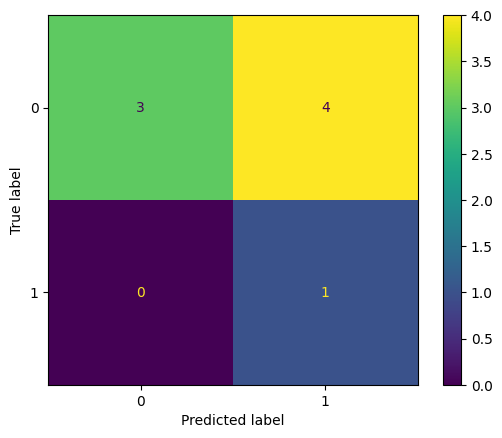

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm).plot()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.43      0.60         7
         1.0       0.20      1.00      0.33         1

    accuracy                           0.50         8
   macro avg       0.60      0.71      0.47         8
weighted avg       0.90      0.50      0.57         8

